# PME3481 - Controle e Aplicações

## Observador de Estados

### Configuração do Ambiente e Bibliotecas

Introdução das bibliotecas mais importantes.

In [2]:
# !pip install numpy --quiet
# !pip install matplotlib --quiet
# !pip install control --quiet


In [3]:
import numpy as np
import scipy 
import scipy.linalg as la
import matplotlib.pyplot as plt
import control as ctrl

In [4]:
def lqr(A, B, Q, R):
    """
    Parameters:
        A (numpy.ndarray): State matrix.
        B (numpy.ndarray): Input matrix.
        Q (numpy.ndarray): State cost matrix.
        R (numpy.ndarray): Input cost matrix.

    Returns:
        K (numpy.ndarray): Feedback gain matrix.
    """
    P = la.solve_continuous_are(A, B, Q, R)

    # Calculate the feedback gain matrix
    K = np.linalg.inv(R) @ B.T @ P
    return K

In [5]:
Xcm = 1.052
Xpe = 0.261
L = 3.304
Df = 0.127
Tlin = 230.57
Izz = 15.07
M = 23.545
g = 9.8055
dar = 1.091
Cd = 0.432
Vxlin = -10.0

# X = [x,y,theta,xp,yp,thetap]
# Xp = [xp,yp,thetap,xpp,ypp,thetapp]
A = np.array([[0, 0, 0, 1],
              [(1/M)*((1/2)*dar*Cd*Vxlin**2*L*Df), (1/M)*(Vxlin *dar*Cd*((Df/2)**2*np.pi)), 0, 0],
              [(1/M)*(-M*g+(1/2)*Vxlin**2*dar*Cd*(np.pi*(Df/2)**2)), 0, 0, 0],
              [(1/Izz)*((1/2)*Vxlin**2*dar*Xpe*Cd*(np.pi*(Df/2)**2)), 0, 0, 0]])

B = np.array([[0, 0],
              [1/M, 0],
              [0, -Tlin/M],
              [0, -Tlin*Xcm/Izz]])

C = np.array([[ 1, 0, 0, 0],
              [ 0, 1, 0, 0],
              [ 0, 0, 1, 0],
              [ 0, 0, 0, 1]])

D = np.array([[ 0, 0],
              [ 0, 0],
              [ 0, 0],
              [ 0, 0]])

In [15]:
# Primeiro passo é calcular o L, para isso vou criar um sistema com A transposto e C transposto no lugar do B

p = [-1 ,  -0.5 - 0.24j,  -0.5 + 0.24j ,-2 ]

#p = [-2.5,-2.5, -3,-1]

# Calculate the gain matrix K using pole placement
Kbun = scipy.signal.place_poles(A.T, C.T, p, method='YT')
Kobs = Kbun.gain_matrix

L = Kobs.T
print(L)

[[ 2.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e+00]
 [ 4.19975124e-01  9.97464246e-01 -0.00000000e+00 -0.00000000e+00]
 [-9.79282123e+00 -0.00000000e+00  5.00000000e-01  2.40000000e-01]
 [ 5.17014925e-03 -0.00000000e+00 -2.40000000e-01  5.00000000e-01]]


In [16]:
#Pegando o K do meu sistema com LQR

Q = np.diag([1, 10, 1,1])          # don't turn too sharply
R = np.diag([0.1, 150])  

Klqr = lqr(A,B, Q, R)

print(Klqr)

[[ 0.52063658  9.90007058  0.28397527 -0.08099821]
 [-0.78271178 -0.0231869   0.08131977 -0.37564641]]


In [17]:
#Para a simulação do observador, tenho que expandir meu vetor variável de estado, a fim de acrescentar o Erro

Acl = A - np.dot(B, Klqr)

Aobs = A - np.dot(L, C)

Atot = np.block([[Acl, np.dot(B,Klqr)],
                [np.zeros_like(A), Aobs]])
Btot = np.block([[B], [np.zeros_like(B)]])
Ctot = np.eye(Atot.shape[0])
Dtot = np.zeros((Atot.shape[0], Btot.shape[1]))

print("Novo A =",Atot)
print("\n")
print("Novo B =",Btot)
print("\n")
print("Novo C =",Ctot)
print("\n")
print("Novo D =",Dtot)

Novo A = [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.97862719e-01 -4.23010190e-01 -1.20609587e-02  3.44014498e-03
   2.21124051e-02  4.20474435e-01  1.20609587e-02 -3.44014498e-03]
 [-1.74577121e+01 -2.27063193e-01  7.96343168e-01 -3.67860666e+00
   7.66489089e+00  2.27063193e-01 -7.96343168e-01  3.67860666e+00]
 [-1.25929910e+01 -3.73205404e-01  1.30888485e+00 -6.04622820e+00
   1.25981611e+01  3.73205404e-01 -1.30888485e+00  6.04622820e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -5.00000000e-01 -2.40000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000000

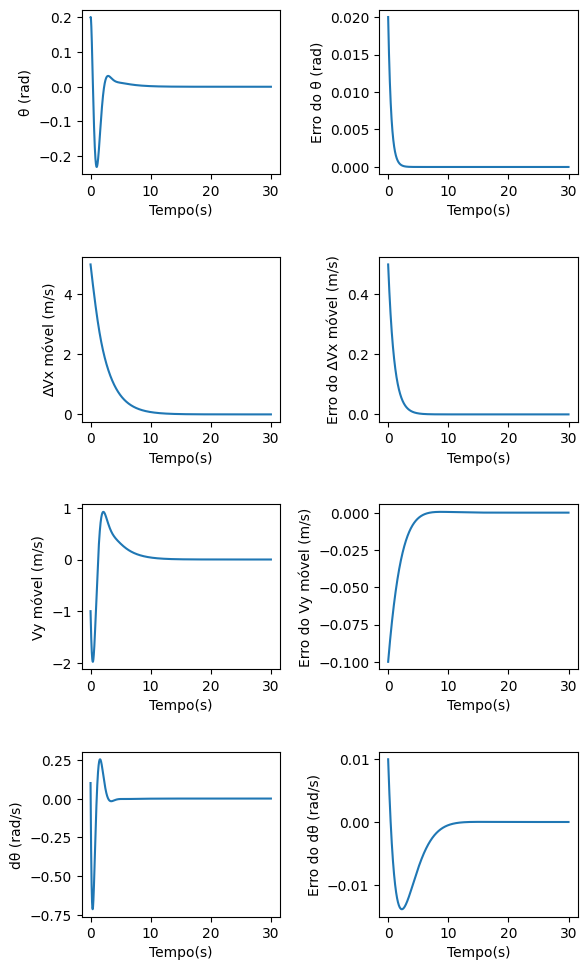

In [18]:
# Com o novo sistema, basta realizar as simulações

sysobs = ctrl.ss(Atot, Btot, Ctot, Dtot)

tempo = np.linspace(0, 30, 400000)
e0 = 10 #em % do valor inicial respectivo
X0_x = [0.2, 5, -1, 0.1] #Valores iniciais dos estados 
X0  = [X0_x[0], X0_x[1], X0_x[2], X0_x[3],X0_x[0] * e0/100,X0_x[1] * e0/100 ,X0_x[2] * e0/100,X0_x[3] * e0/100]

t, amp,yr = ctrl.forced_response(sysobs, tempo, 0 ,X0 ,return_x = 'True')

f,((ax1, ax2), (ax3,ax4), (ax5, ax6), (ax7,ax8)) = plt.subplots(4, 2)
plt.subplots_adjust(right=0.9, top=2, wspace=0.5,hspace=0.5)
ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
ax3.set_xlabel('Tempo(s)')
ax4.set_xlabel('Tempo(s)')
ax5.set_xlabel('Tempo(s)')
ax6.set_xlabel('Tempo(s)')
ax7.set_xlabel('Tempo(s)')
ax8.set_xlabel('Tempo(s)')

ax1.plot(t, yr[0])
ax1.set_ylabel('θ (rad)')

ax2.plot(t, yr[4])
ax2.set_ylabel('Erro do θ (rad)')

ax3.plot(t, yr[1])
ax3.set_ylabel('∆Vx móvel (m/s)')

ax4.plot(t, yr[5])
ax4.set_ylabel('Erro do ∆Vx móvel (m/s)')

ax5.plot(t, yr[2])
ax5.set_ylabel('Vy móvel (m/s)')

ax6.plot(t, yr[6])
ax6.set_ylabel('Erro do Vy móvel (m/s)')

ax7.plot(t, yr[3])
ax7.set_ylabel('dθ (rad/s)')

ax8.plot(t, yr[7])
ax8.set_ylabel('Erro do dθ (rad/s)')
plt.show(block=False)

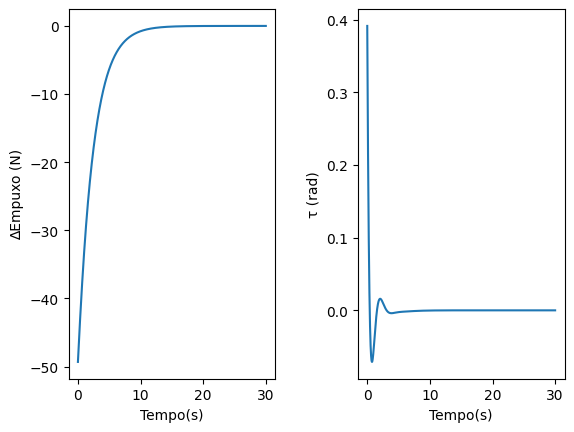

In [19]:
u = np.dot(-Klqr,[yr[0],yr[1],yr[2],yr[3]])
f,(ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(right=0.9, wspace=0.4,hspace=0.5)
ax1.plot(t, u[0])
ax1.set_ylabel('∆Empuxo (N)')

ax2.plot(t, u[1])
ax2.set_ylabel('τ (rad)')
ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
plt.show(block=False)